First version of a working network for test

- Why is there exactly the same value of stddev for each image and each tests?? (in e1, e2 and z) : because of the 'relu' activation in last dense layer. It prevented covariance matrice to have negative terms and consequently the learning of covariance was limited. This is now modified.

Second version

- try to output shapes and redshit of all galaxies put randomly on a stamp. Shift sample in [-3,2 ; 3,2]arcsecond around the center of the image

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from importlib import reload

In [2]:
import sys
import os
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from tools_for_VAE import utils, vae_functions, generator, model

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

In [5]:
tfd = tfp.distributions

In [6]:
import tensorflow

# Parameters

In [7]:
nb_of_bands = 6
batch_size = 100 

nbmax_gal =4

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
final_dim = 3*nbmax_gal
filters = [32, 64, 128, 256, 512]
kernels = [3,3,3,3, 3]

conv_activation = None
dense_activation = None

bands = [4,5,6,7,8,9]

# Data loading

## Batchgenerator

In [8]:
images_dir = '/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/blended_galaxies/random/'
root = 'galaxies_blended_20191024'
data_dir = images_dir + 'test/'
list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]

In [9]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [13]:
test_generator = generator.BatchGenerator_multi_galaxies(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='test',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)


[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [29]:
a = test_generator.__getitem__(2)

In [30]:
a[0].shape

(100, 64, 64, 6)

In [31]:
a[1].shape

(100, 9)

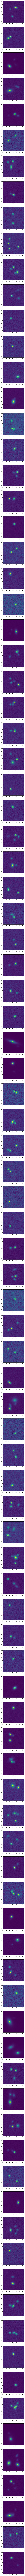

In [32]:
fig, axes = plt.subplots(100, 1, figsize=(5,500))

for i in range (100):
    axes[i].imshow(a[0][i][:,:,2])

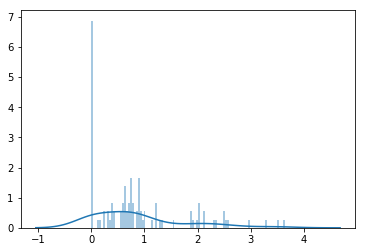

In [41]:
sns.distplot(a[1][:,2], bins = 100)

In [67]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [51]:
df['nb_blended_gal'][0]

4

In [53]:
np.argmin((df['mag_1'][0], df['mag_2'][0], df['mag_3'][0]))

0

In [55]:
_idx = np.argmin((df['mag_1'][0], df['mag_2'][0], df['mag_3'][0]))

In [56]:
_idx

0

In [58]:
print(df['mag_1'][0],df['mag_2'][0], df['mag_3'][0]) 

27.243195443597642 27.4073272908254 27.344204900997678


In [63]:
df_test = pd.DataFrame()
df[df==10]=30

In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

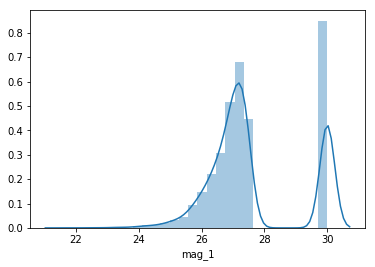

In [66]:
sns.distplot(df['mag_1'])

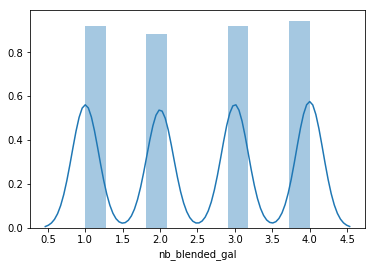

In [17]:
sns.distplot(df['nb_blended_gal'])

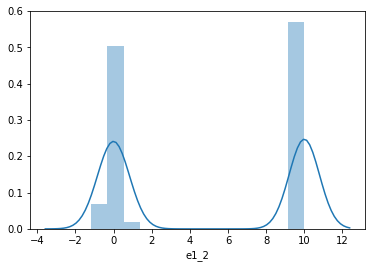

In [35]:
sns.distplot(df['e1_2'])

In [36]:
a = test_generator.__getitem__(2)

In [37]:
a[1].shape

(100, 4)

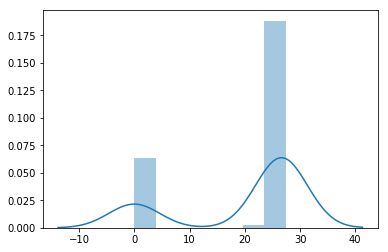

In [45]:
sns.distplot(a[1][:,3])

In [128]:
a[1][:,10]

array([ 1.00000000e+01,  8.79317895e-03,  1.00000000e+01,  1.00000000e+01,
        1.55080602e-01,  1.00000000e+01,  1.00000000e+01,  4.22886103e-01,
        1.00000000e+01,  1.00000000e+01,  1.00000000e+01, -5.15704393e-01,
        1.00000000e+01, -2.73634613e-01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01, -3.83366138e-01,  1.00000000e+01, -4.41035628e-01,
       -2.22879007e-01,  1.00000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01, -5.76420009e-01,  3.74008805e-01,
       -4.23720330e-02,  1.00000000e+01,  1.00000000e+01, -4.69746105e-02,
        1.00000000e+01,  2.35415876e-01,  1.00000000e+01, -9.79589447e-02,
        2.17093691e-01,  1.00000000e+01,  1.00000000e+01, -3.35853882e-02,
        1.00000000e+01,  

# Model with latent space

## Model architecture

In [13]:
net = model.create_model(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)

In [14]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu (PReLU)              (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496 

In [12]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/test_2/'

latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)

## Test

In [13]:
n = 10

In [14]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

In [30]:
test_data.shape

(1000, 64, 64, 6)

In [31]:
out = net(test_data)

In [32]:
# Compute ellipticities in [0,1], inverse function of the one in the generator
out_mean = np.zeros((n*batch_size,3))

out_mean[:,0] = out.mean().numpy()[:,0]#np.log(out.mean().numpy()[:,0]/2)
out_mean[:,1] = out.mean().numpy()[:,1]#np.log(out.mean().numpy()[:,1]/2)
out_mean[:,2] = out.mean().numpy()[:,2]
                    
                    
out_stddev = np.zeros((n*batch_size,3))

out_stddev[:,0] = out.stddev().numpy()[:,0]#np.log(out.stddev().numpy()[:,0]/2)
out_stddev[:,1] = out.stddev().numpy()[:,1]#np.log(out.stddev().numpy()[:,1]/2)
out_stddev[:,2] = out.stddev().numpy()[:,2]

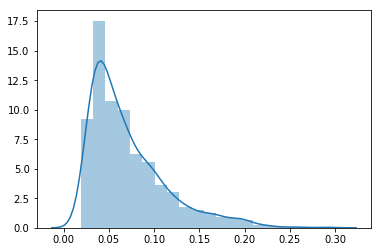

In [33]:
sns.distplot(out_stddev[:,0], bins = 20)

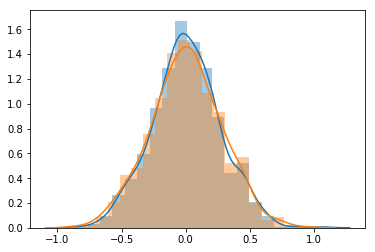

In [34]:
sns.distplot(out_mean[:,0], bins = 20)
sns.distplot(test_labels[:, 0], bins = 20)

### One sampling for 1000 images (ten batch)

Text(0.5, 1.0, '$z$')

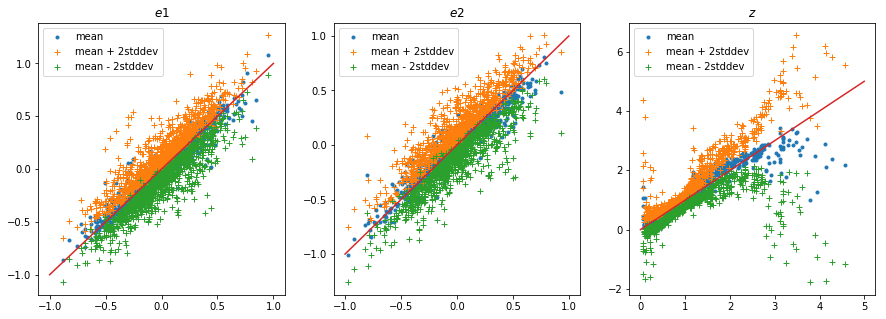

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_labels[:, 0], out_mean[:,0], '.', label = 'mean')
axes[0].plot(test_labels[:, 0], out_mean[:,0]+ 2*out_stddev[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test_labels[:, 0], out_mean[:,0]- 2*out_stddev[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-0.5,6.5)
axes[0].set_title('$e1$')

axes[1].plot(test_labels[:, 1], out_mean[:,1], '.', label = 'mean')
axes[1].plot(test_labels[:, 1], out_mean[:,1]+ 2*out_stddev[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test_labels[:, 1], out_mean[:,1]- 2*out_stddev[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-0.5,6.5)
axes[1].set_title('$e2$')

axes[2].plot(test_labels[:,2], out_mean[:,2], '.', label = 'mean')
axes[2].plot(test_labels[:,2], out_mean[:,2]+ 2*out_stddev[:,2], '+', label = 'mean + 2stddev')
axes[2].plot(test_labels[:,2], out_mean[:,2]- 2*out_stddev[:,2], '+', label = 'mean - 2stddev')
x = np.linspace(0,5)
axes[2].plot(x, x)
axes[2].legend()
#axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')

### N samplings for 100 images (one batch)

In [36]:
N = 100
means_e1 = np.zeros((N,100))
stddevs_e1 = np.zeros((N,100))
means_e2 = np.zeros((N,100))
stddevs_e2 = np.zeros((N,100))
means_z = np.zeros((N,100))
stddevs_z = np.zeros((N,100))

outs = np.zeros((N,100))
for i in range (N):
    out = net(test_data[:100])
    outs[i] = out[:,0].numpy()
    means_e1[i] = out.mean().numpy()[:,0]
    stddevs_e1[i] = out.stddev().numpy()[:,0]
    means_e2[i] = out.mean().numpy()[:,1]
    stddevs_e2[i] = out.stddev().numpy()[:,1]
    means_z[i] = out.mean().numpy()[:,2]
    stddevs_z[i] = out.stddev().numpy()[:,2]

#### E1

In [52]:
image_nb = 0

0.10704660415649414


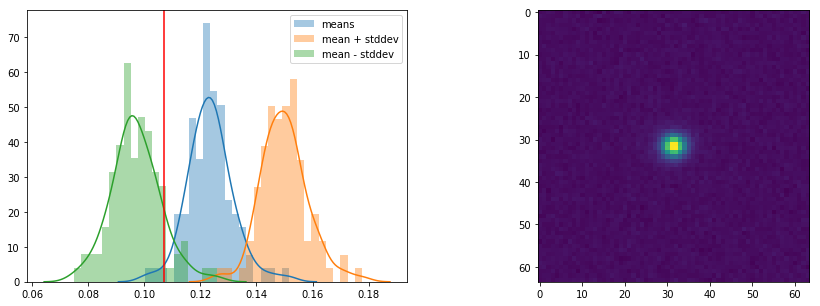

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e1[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e1[:,image_nb] + stddevs_e1[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e1[:,image_nb] - stddevs_e1[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].legend()
print(test_labels[image_nb,0])

axes[1].imshow(test_data[image_nb,:,:,2])

#### E2

0.006916262675076722


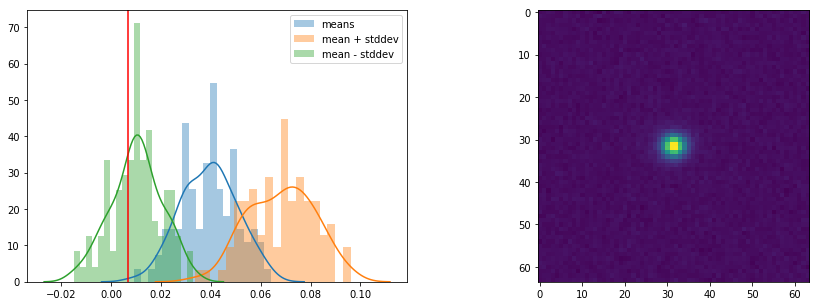

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e2[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e2[:,image_nb] + stddevs_e2[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e2[:,image_nb] - stddevs_e2[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].legend()
print(test_labels[image_nb,1])

axes[1].imshow(test_data[image_nb,:,:,2])

#### Redshift

0.7778000235557556


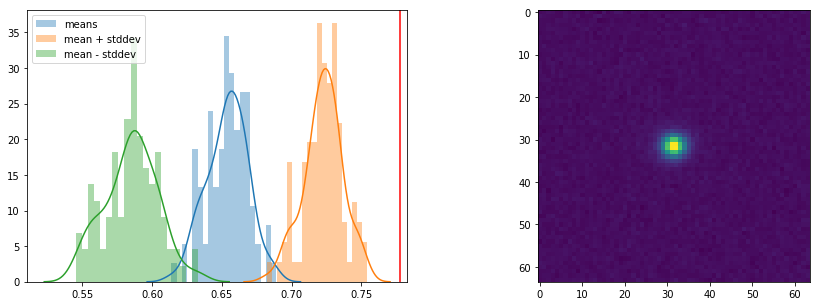

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_z[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_z[:,image_nb] + stddevs_z[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_z[:,image_nb] - stddevs_z[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].legend()
print(test_labels[image_nb,2])

axes[1].imshow(test_data[image_nb,:,:,2])

#### Distributions

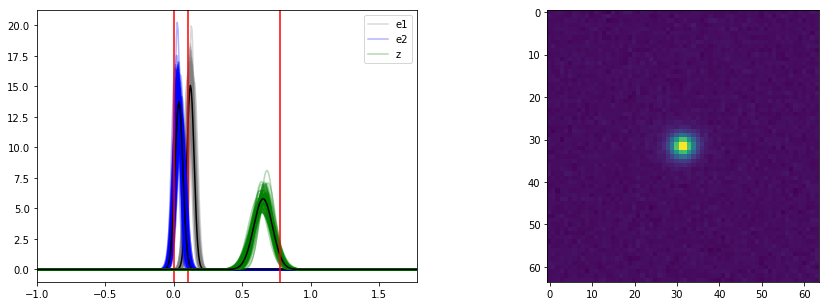

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3)
    if i == len(means_e1)-1 : 
        axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3 , label = 'e1')
mean_means = np.mean(means_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2')
mean_means = np.mean(means_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3, label = 'z')
mean_means = np.mean(means_z[:,image_nb])
mean_stddevs = np.mean(stddevs_z[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()


### Other example

In [43]:
image_nb = 1

0.01636376418173313


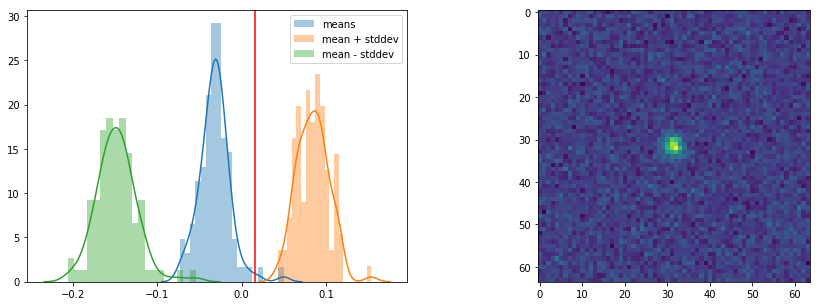

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e1[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e1[:,image_nb] + stddevs_e1[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e1[:,image_nb] - stddevs_e1[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].legend()
print(test_labels[image_nb,0])

axes[1].imshow(test_data[image_nb,:,:,2])

0.3566828668117523


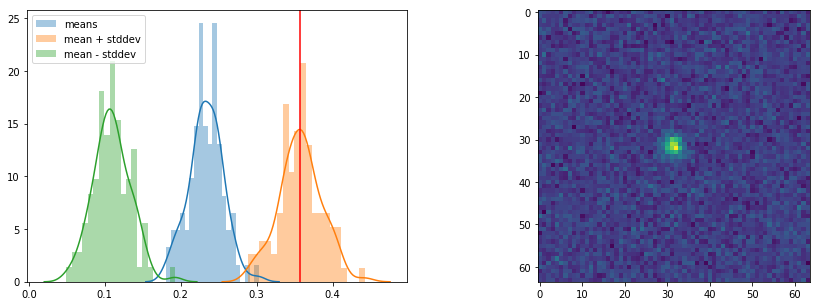

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e2[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e2[:,image_nb] + stddevs_e2[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e2[:,image_nb] - stddevs_e2[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].legend()
print(test_labels[image_nb,1])

axes[1].imshow(test_data[image_nb,:,:,2])

0.5582000017166138


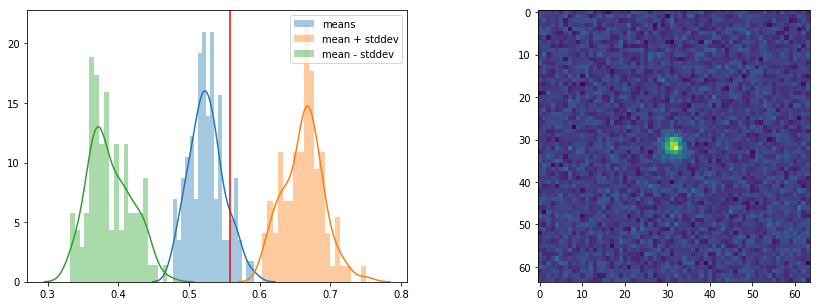

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_z[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_z[:,image_nb] + stddevs_z[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_z[:,image_nb] - stddevs_z[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].legend()
print(test_labels[image_nb,2])

axes[1].imshow(test_data[image_nb,:,:,2])

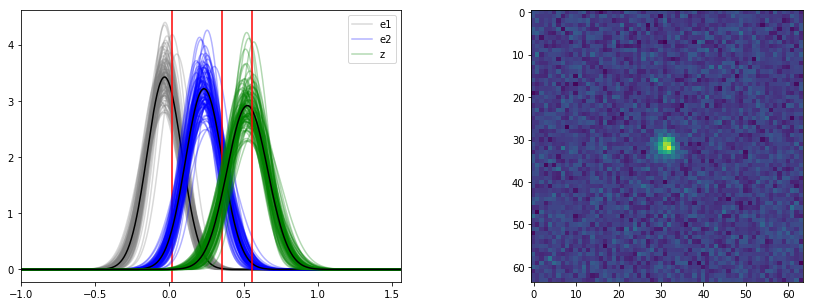

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3)
    if i == len(means_e1)-1 : 
        axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3 , label = 'e1')
mean_means = np.mean(means_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2')
mean_means = np.mean(means_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3, label = 'z')
mean_means = np.mean(means_z[:,image_nb])
mean_stddevs = np.mean(stddevs_z[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()


# Model without latent space

## Model architecture

In [24]:
reload(model)

<module 'tools_for_VAE.model' from '../../scripts/tools_for_VAE/tools_for_VAE/model.py'>

In [10]:
net_wo_ls = model.create_model_wo_ls(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)

In [11]:
net_wo_ls.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu (PReLU)              (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496 

In [32]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/blended/'

latest = tf.train.latest_checkpoint(loading_path)
net_wo_ls.load_weights(latest)

## Test

In [33]:
n = 10

In [34]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

In [35]:
out = net_wo_ls(test_data)

In [36]:
# Compute ellipticities in [0,1], inverse function of the one in the generator
out_mean = np.zeros((n*batch_size,3))

out_mean[:,0] = out.mean().numpy()[:,0]
out_mean[:,1] = out.mean().numpy()[:,1]
out_mean[:,2] = out.mean().numpy()[:,2]
                    
                    
out_stddev = np.zeros((n*batch_size,3))

out_stddev[:,0] = out.stddev().numpy()[:,0]
out_stddev[:,1] = out.stddev().numpy()[:,1]
out_stddev[:,2] = out.stddev().numpy()[:,2]

### One sampling for 1000 images (ten batch)

Text(0.5, 1.0, '$z$')

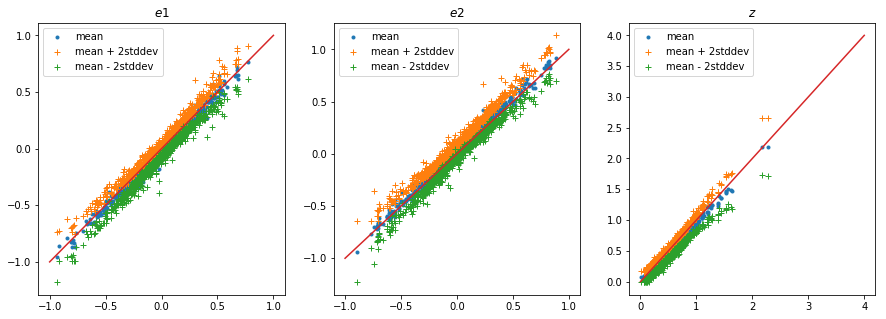

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_labels[:, 0], out_mean[:,0], '.', label = 'mean')
axes[0].plot(test_labels[:, 0], out_mean[:,0]+ 2*out_stddev[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test_labels[:, 0], out_mean[:,0]- 2*out_stddev[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-0.5,6.5)
axes[0].set_title('$e1$')

axes[1].plot(test_labels[:, 1], out_mean[:,1], '.', label = 'mean')
axes[1].plot(test_labels[:, 1], out_mean[:,1]+ 2*out_stddev[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test_labels[:, 1], out_mean[:,1]- 2*out_stddev[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-0.5,6.5)
axes[1].set_title('$e2$')

axes[2].plot(test_labels[:,2], out_mean[:,2], '.', label = 'mean')
axes[2].plot(test_labels[:,2], out_mean[:,2]+ 2*out_stddev[:,2], '+', label = 'mean + 2stddev')
axes[2].plot(test_labels[:,2], out_mean[:,2]- 2*out_stddev[:,2], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[2].plot(x, x)
axes[2].legend()
#axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')

#### Distribution

In [38]:
N = 100
means_e1 = np.zeros((N,100))
stddevs_e1 = np.zeros((N,100))
means_e2 = np.zeros((N,100))
stddevs_e2 = np.zeros((N,100))
means_z = np.zeros((N,100))
stddevs_z = np.zeros((N,100))

outs = np.zeros((N,100))
for i in range (N):
    out = net_wo_ls(test_data[:100])
    outs[i] = out[:,0].numpy()
    means_e1[i] = out.mean().numpy()[:,0]
    stddevs_e1[i] = out.stddev().numpy()[:,0]
    means_e2[i] = out.mean().numpy()[:,1]
    stddevs_e2[i] = out.stddev().numpy()[:,1]
    means_z[i] = out.mean().numpy()[:,2]
    stddevs_z[i] = out.stddev().numpy()[:,2]

In [39]:
image_nb = 1

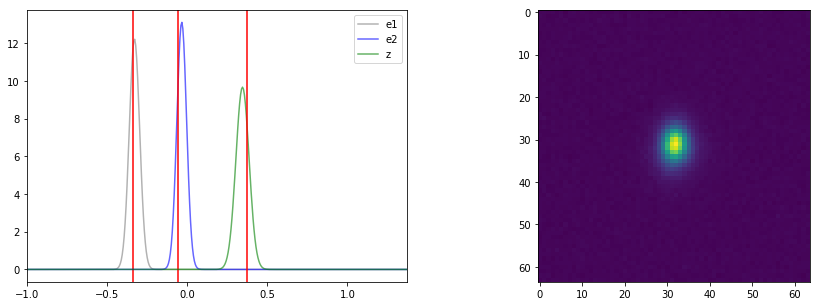

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
axes[0].axvline(test_labels[image_nb,1], color = 'r')


axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()

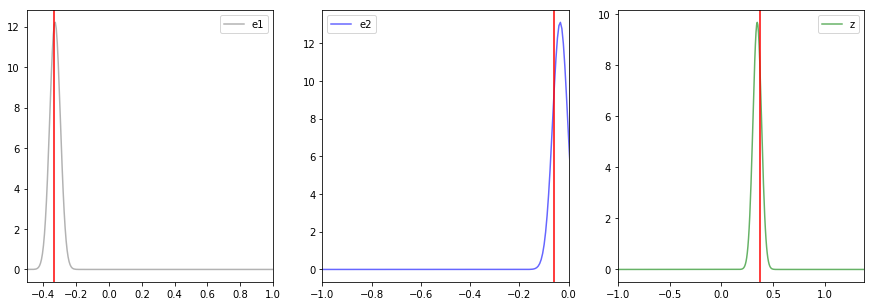

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].set_xlim(-0.5,1)

axes[1].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
axes[1].axvline(test_labels[image_nb,1], color = 'r')
axes[1].set_xlim(-1,0)

axes[2].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
axes[2].axvline(test_labels[image_nb,2], color = 'r')
axes[2].set_xlim(-1,test_labels[image_nb,2]+1)

#axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()
axes[1].legend()
axes[2].legend()

### Other example

In [137]:
image_nb = 1

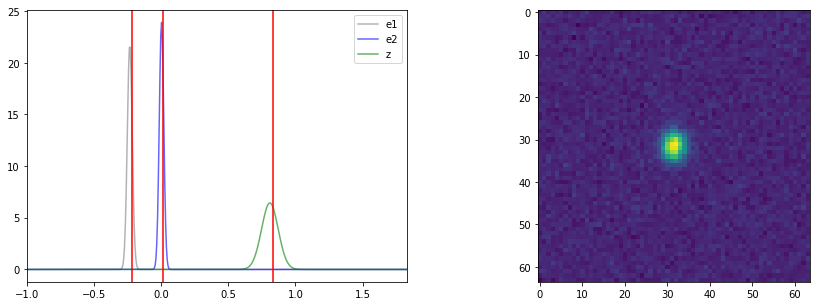

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
# mean_means = np.mean(means_e1[:,image_nb])
# mean_stddevs = np.mean(stddevs_e1[:,image_nb])
# axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
# mean_means = np.mean(means_e2[:,image_nb])
# mean_stddevs = np.mean(stddevs_e2[:,image_nb])
# axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')


axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
#mean_means = np.mean(means_z[:,image_nb])
#mean_stddevs = np.mean(stddevs_z[:,image_nb])
#axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()

# Comparison of with/without latent space

## One sampling for 1000 images (ten batch)

In [88]:
n = 10

In [89]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

test_data.shape

(1000, 64, 64, 6)

In [90]:
out_with = net(test_data)
out_without = net_wo_ls(test_data)

E1

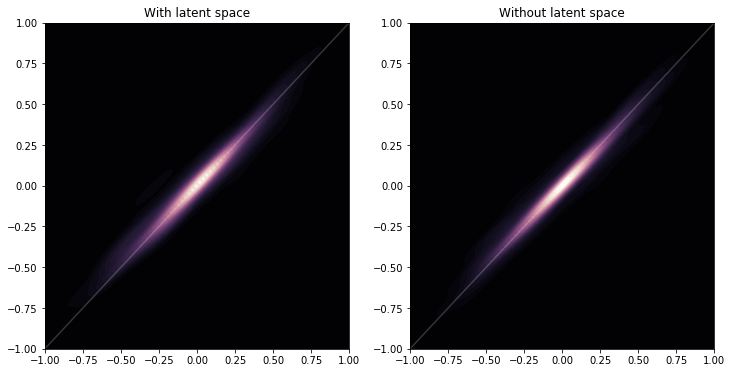

In [37]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 0], out_with.mean().numpy()[:,0], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].plot(x,x, color = 'white', alpha = 0.2)

sns.kdeplot(test_labels[:, 0], out_without.mean().numpy()[:,0], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

E2

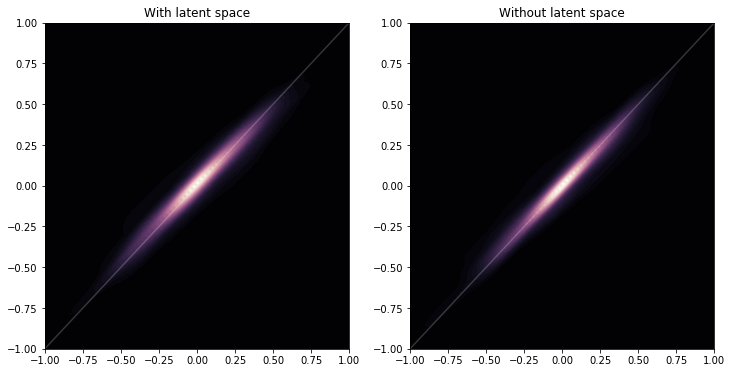

In [38]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 1], out_with.mean().numpy()[:,1], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].plot(x,x, color = 'white', alpha = 0.2)
sns.kdeplot(test_labels[:, 1], out_without.mean().numpy()[:,1], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

Redshift

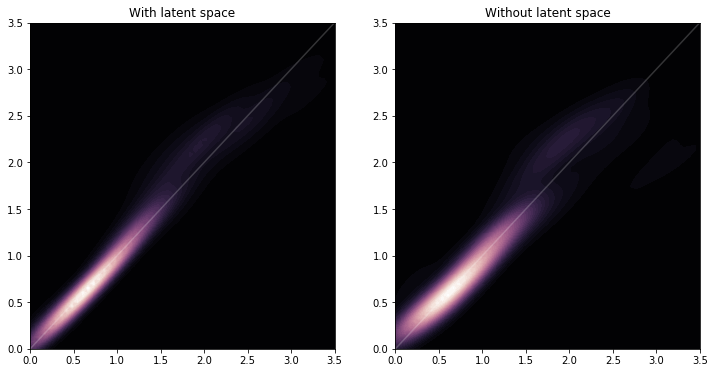

In [40]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(0,3.5)
ax[0].set_ylim(0,3.5)
ax[0].plot(x,x, color = 'white', alpha = 0.2)
sns.kdeplot(test_labels[:, 2], out_without.mean().numpy()[:,2], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(0,3.5)
ax[1].set_ylim(0,3.5)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

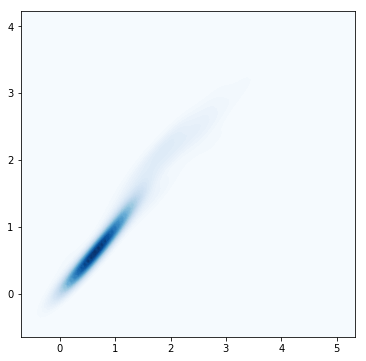

In [93]:
f, ax = plt.subplots(1,figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap='Reds', n_levels=60, shade=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap='Blues', n_levels=60, shade=True)
#ax.title('With latent space')
x = np.linspace(-10,10,1000)
#ax.xlim(0,3.5)
#ax.ylim(0,3.5)
#ax.plot(x,x, color = 'white', alpha = 0.2)


### N samplings for 100 images (one batch)

In [84]:
N = 100
means_with_e1 = np.zeros((N,100))
stddevs_with_e1 = np.zeros((N,100))
means_with_e2 = np.zeros((N,100))
stddevs_with_e2 = np.zeros((N,100))
means_with_z = np.zeros((N,100))
stddevs_with_z = np.zeros((N,100))

means_without_e1 = np.zeros((1,100))
stddevs_without_e1 = np.zeros((1,100))
means_without_e2 = np.zeros((1,100))
stddevs_without_e2 = np.zeros((1,100))
means_without_z = np.zeros((1,100))
stddevs_without_z = np.zeros((1,100))

outs_with = np.zeros((N,100))
for i in range (N):
    out_with = net(test_data[:100])
    outs_with[i] = out_with[:,0].numpy()
    means_with_e1[i] = out_with.mean().numpy()[:,0]
    stddevs_with_e1[i] = out_with.stddev().numpy()[:,0]
    means_with_e2[i] = out_with.mean().numpy()[:,1]
    stddevs_with_e2[i] = out_with.stddev().numpy()[:,1]
    means_with_z[i] = out_with.mean().numpy()[:,2]
    stddevs_with_z[i] = out_with.stddev().numpy()[:,2]

out_without = net_wo_ls(test_data[:100])
means_without_e1[0] = out_without.mean().numpy()[:,0]
stddevs_without_e1[0] = out_without.stddev().numpy()[:,0]
means_without_e2[0] = out_without.mean().numpy()[:,1]
stddevs_without_e2[0] = out_without.stddev().numpy()[:,1]
means_without_z[0] = out_without.mean().numpy()[:,2]
stddevs_without_z[0] = out_without.stddev().numpy()[:,2]


#### Distribution

e1: 0.5382068157196045 e0: -0.1400725394487381 redshift: 1.2489999532699585


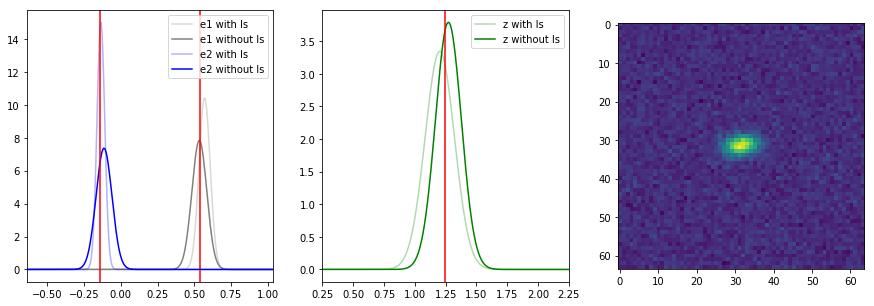

In [85]:
image_nb = 0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_without_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_e1[0,image_nb])/(2*stddevs_without_e1[0,image_nb]**2))), color = 'grey', alpha = 0.3, label = 'e1 with ls')
mean_means = np.mean(means_with_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_with_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'grey', alpha = 1, label = 'e1 without ls')    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_without_e2[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_e2[0,image_nb])/(2*stddevs_without_e2[0,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2 with ls')
mean_means = np.mean(means_with_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_with_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'b', alpha = 1, label = 'e2 without ls')    
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].set_xlim(np.min((test_labels[image_nb,0]-0.5, test_labels[image_nb,1]-0.5)),np.max((test_labels[image_nb,0]+0.5, test_labels[image_nb,1]+0.5)))

axes[1].plot(x, (1/(stddevs_without_z[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_z[0,image_nb])/(2*stddevs_without_z[0,image_nb]**2))), color = 'green', alpha = 0.3, label= 'z with ls')
mean_means = np.mean(means_with_z[:,image_nb])
mean_stddevs = np.mean(stddevs_with_z[:,image_nb])
axes[1].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'green', alpha = 1, label= 'z without ls')    
axes[1].axvline(test_labels[image_nb,2], color = 'r')
axes[1].set_xlim(test_labels[image_nb,2]-1,test_labels[image_nb,2]+1)

axes[2].imshow(test_data[image_nb,:,:,2])
axes[0].legend()
axes[1].legend()

print('e1: '+str(test_labels[image_nb,0]), 'e0: '+str(test_labels[image_nb,1]),'redshift: ' +str(test_labels[image_nb,2]))

# Model full probabilistic

## Model architecture

In [11]:
reload(model)

<module 'tools_for_VAE.model' from '../../scripts/tools_for_VAE/tools_for_VAE/model.py'>

In [12]:
net = model.create_model_full_prob(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)

In [13]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_flipout_10 (Conv2DFli (None, 64, 64, 32)        3488      
_________________________________________________________________
p_re_lu_10 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_flipout_11 (Conv2DFli (None, 32, 32, 32)        18464     
_________________________________________________________________
p_re_lu_11 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_flipout_12 (Conv2DFli (None, 32, 32, 64)        36928 

In [ ]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/test_3/'

latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)

## Test

In [ ]:
n = 10

In [ ]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

In [ ]:
test_data.shape

In [ ]:
out = net(test_data)

In [ ]:
# Compute ellipticities in [0,1], inverse function of the one in the generator
out_mean = np.zeros((n*batch_size,3))

out_mean[:,0] = out.mean().numpy()[:,0]#np.log(out.mean().numpy()[:,0]/2)
out_mean[:,1] = out.mean().numpy()[:,1]#np.log(out.mean().numpy()[:,1]/2)
out_mean[:,2] = out.mean().numpy()[:,2]
                    
                    
out_stddev = np.zeros((n*batch_size,3))

out_stddev[:,0] = out.stddev().numpy()[:,0]#np.log(out.stddev().numpy()[:,0]/2)
out_stddev[:,1] = out.stddev().numpy()[:,1]#np.log(out.stddev().numpy()[:,1]/2)
out_stddev[:,2] = out.stddev().numpy()[:,2]

In [ ]:
sns.distplot(out_stddev[:,0], bins = 20)

In [ ]:
sns.distplot(out_mean[:,0], bins = 20)
sns.distplot(test_labels[:, 0], bins = 20)

### One sampling for 1000 images (ten batch)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_labels[:, 0], out_mean[:,0], '.', label = 'mean')
axes[0].plot(test_labels[:, 0], out_mean[:,0]+ 2*out_stddev[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test_labels[:, 0], out_mean[:,0]- 2*out_stddev[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-0.5,6.5)
axes[0].set_title('$e1$')

axes[1].plot(test_labels[:, 1], out_mean[:,1], '.', label = 'mean')
axes[1].plot(test_labels[:, 1], out_mean[:,1]+ 2*out_stddev[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test_labels[:, 1], out_mean[:,1]- 2*out_stddev[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-0.5,6.5)
axes[1].set_title('$e2$')

axes[2].plot(test_labels[:,2], out_mean[:,2], '.', label = 'mean')
axes[2].plot(test_labels[:,2], out_mean[:,2]+ 2*out_stddev[:,2], '+', label = 'mean + 2stddev')
axes[2].plot(test_labels[:,2], out_mean[:,2]- 2*out_stddev[:,2], '+', label = 'mean - 2stddev')
x = np.linspace(0,5)
axes[2].plot(x, x)
axes[2].legend()
#axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')

### N samplings for 100 images (one batch)

In [ ]:
N = 100
means_e1 = np.zeros((N,100))
stddevs_e1 = np.zeros((N,100))
means_e2 = np.zeros((N,100))
stddevs_e2 = np.zeros((N,100))
means_z = np.zeros((N,100))
stddevs_z = np.zeros((N,100))

outs = np.zeros((N,100))
for i in range (N):
    out = net(test_data[:100])
    outs[i] = out[:,0].numpy()
    means_e1[i] = out.mean().numpy()[:,0]
    stddevs_e1[i] = out.stddev().numpy()[:,0]
    means_e2[i] = out.mean().numpy()[:,1]
    stddevs_e2[i] = out.stddev().numpy()[:,1]
    means_z[i] = out.mean().numpy()[:,2]
    stddevs_z[i] = out.stddev().numpy()[:,2]

#### E1

In [ ]:
image_nb = 0

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e1[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e1[:,image_nb] + stddevs_e1[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e1[:,image_nb] - stddevs_e1[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].legend()
print(test_labels[image_nb,0])

axes[1].imshow(test_data[image_nb,:,:,2])

#### E2

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e2[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e2[:,image_nb] + stddevs_e2[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e2[:,image_nb] - stddevs_e2[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].legend()
print(test_labels[image_nb,1])

axes[1].imshow(test_data[image_nb,:,:,2])

#### Redshift

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_z[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_z[:,image_nb] + stddevs_z[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_z[:,image_nb] - stddevs_z[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].legend()
print(test_labels[image_nb,2])

axes[1].imshow(test_data[image_nb,:,:,2])

#### Distributions

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3)
    if i == len(means_e1)-1 : 
        axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3 , label = 'e1')
mean_means = np.mean(means_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2')
mean_means = np.mean(means_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3, label = 'z')
mean_means = np.mean(means_z[:,image_nb])
mean_stddevs = np.mean(stddevs_z[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()

### Other example

In [ ]:
image_nb = 1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e1[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e1[:,image_nb] + stddevs_e1[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e1[:,image_nb] - stddevs_e1[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].legend()
print(test_labels[image_nb,0])

axes[1].imshow(test_data[image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_e2[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_e2[:,image_nb] + stddevs_e2[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_e2[:,image_nb] - stddevs_e2[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].legend()
print(test_labels[image_nb,1])

axes[1].imshow(test_data[image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means_z[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means_z[:,image_nb] + stddevs_z[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means_z[:,image_nb] - stddevs_z[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].legend()
print(test_labels[image_nb,2])

axes[1].imshow(test_data[image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3)
    if i == len(means_e1)-1 : 
        axes[0].plot(x, (1/(stddevs_e1[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[i,image_nb])/(2*stddevs_e1[i,image_nb]**2))), color = 'grey', alpha = 0.3 , label = 'e1')
mean_means = np.mean(means_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2')
mean_means = np.mean(means_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')

for i in range (len(means_e1)):
    axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3)
    if i == len(means_e1)-1:
        axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.3, label = 'z')
mean_means = np.mean(means_z[:,image_nb])
mean_stddevs = np.mean(stddevs_z[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()